In [1]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import collections as clt
import networkx as nx
import pickle
import itertools
from joblib import Parallel, delayed
import math
from community import best_partition, modularity
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem import WordNetLemmatizer 
from spellchecker import SpellChecker

In [2]:
plt.rcParams["figure.figsize"] = (10,7) #defining size of plots

In [3]:
df = pd.read_csv('reviews_full_v9-2.csv')
df.head()

,User,Date,Year,Month,Release,Band,Score,Link,Album_link,Review_title,...,Band_Genre,Combined_Genre,Key Features,Cleansed Features,Cleansed Text,Product Features,Product Features_dep,neg,neu,pos
0,SpookyApparition,July 11 2002,2002,7,Chaosphere,Meshuggah,82,https://www.metal-archives.com/reviews/Meshugg...,https://www.metal-archives.com/albums/Meshugga...,Technical metal at it's finest.,...,groove metal|thrash metal,technical thrash metal|math metal|progressive ...,originally bought|entire album|sounded variati...,originally bought|entire album|sounded variati...,I originally bought Chaosphere in late 2000......,entire album|sounded variation|grown appreciat...,tacky place|respective instruments|vocal perfo...,0.025,0.826,0.149
1,SpookyApparition,July 14 2002,2002,7,Necroticism_-_Descanting_the_Insalubrious,Carcass,88,https://www.metal-archives.com/reviews/Carcass...,https://www.metal-archives.com/albums/Carcass/...,Carcass at their finest.,...,grindcore|death metal,grindcore|melodic death metal,somewhat song structures|song structures|injec...,somewhat song structures|song structures|injec...,A midpoint between Carcass' early grind albums...,somewhat song structures|song structures|injec...,melodic variety|vocal performances|enjoyable a...,0.038,0.850,0.111
2,MarkRyan,July 15 2002,2002,7,Angels_Fall_First,Nightwish,90,https://www.metal-archives.com/reviews/Nightwi...,https://www.metal-archives.com/albums/Nightwis...,On par with their other stuff...,...,symphonic metal|power metal,symphonic power metal,general consensus|lose credibility|sung poet|b...,general consensus|lose credibility|sung poet|b...,"I'm not hard-core into metal at all, really, b...",general consensus|lose credibility|sung poet|b...,beautiful melody|beautiful example|general con...,0.026,0.771,0.202
3,Fear,July 16 2002,2002,7,Dark_Genesis,Iced_Earth,87,https://www.metal-archives.com/reviews/Iced_Ea...,https://www.metal-archives.com/albums/Iced_Ear...,Brilliance in Repackaging,...,thrash metal|power metal,heavy metal|us power metal,new album fact|old material|bought big fan|big...,new album fact|old material|bought big fan|big...,"This is not a new album, but in fact, five alb...",new album fact|old material|bought big fan|big...,different versions|original vocals|old materia...,0.031,0.723,0.246
4,Esoteric,July 16 2002,2002,7,A_Night_at_the_Opera,Blind_Guardian,70,https://www.metal-archives.com/reviews/Blind_G...,https://www.metal-archives.com/albums/Blind_Gu...,Somewhat Disappointing,...,speed metal|power metal,power metal,accurate description album|vocal lines|meaty a...,accurate description album|vocal lines|meaty a...,I've been trying for months to come up with an...,accurate description album|vocal lines|meaty a...,catchy songs|bad album|vocal lines|little line...,0.130,0.747,0.123


In [4]:
all_features = pickle.load(open('opinionsv3.p','rb')) #sorted dictionary of phrases + frequency
print(len(all_features))

680777


In [5]:
len([feature for feature in all_features if all_features[feature] > 100])

2651

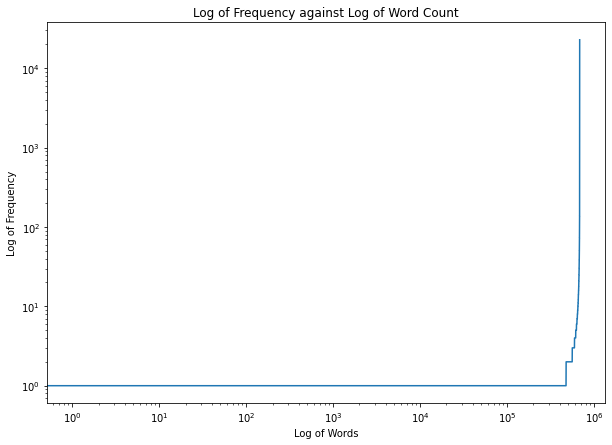

In [6]:
plt.title('Log of Frequency against Log of Word Count')
plt.ylabel('Log of Frequency')
plt.xlabel('Log of Words')
plt.loglog([1]+sorted(all_features.values()))
plt.show()

In [7]:
genre_group = pickle.load(open('genre_group.p','rb'))
lemma = WordNetLemmatizer() 

In [8]:
list(all_features.values())[:10]

[1, 127, 3218, 3813, 58, 2747, 35, 2122, 106, 242]

In [9]:
def isNaN(x):
    return x != x

spell = SpellChecker()
adj_to_genre = {}
t1 = time.time()
all_genres = set()
for i,row in df.iterrows():
    if i%10000 == 0:
        print(i,time.time()-t1)
    if isNaN(row['Product Features_dep']) or isNaN(row['Combined_Genre']):
        continue
    features = row['Product Features_dep'].split('|')
    genres = row['Combined_Genre'].split('|')
    album = row['Release']
    for genre in genres.copy():
        if genre not in genre_group or genre_group[genre] == 'Non-metal' or genre_group[genre] == 'Others':
            genres.remove(genre)
    
    for feature in features:
        adj = lemma.lemmatize(feature.split(' ')[0])
        if len(spell.unknown([adj])) != 0:
            continue
        if adj not in adj_to_genre:
            adj_to_genre[adj] = set()
        for genre in genres:
            adj_to_genre[adj].add(genre)
            all_genres.add(genre)

0 0.09469032287597656
10000 4.218678712844849
20000 7.163754224777222
30000 10.458091020584106
40000 13.909595727920532
50000 17.34326171875
60000 20.918671131134033
70000 24.65713405609131
80000 28.49202251434326
90000 32.41213035583496


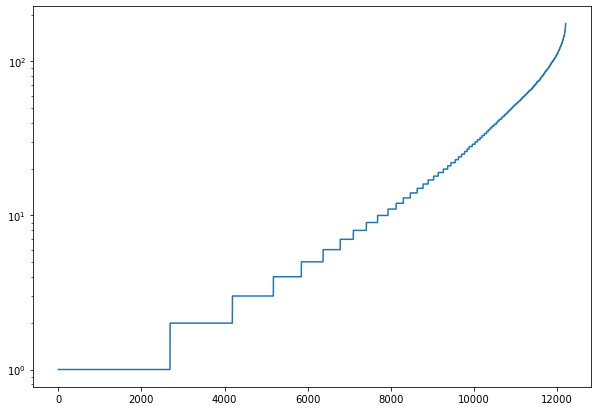

In [10]:
genfreq = {}
for adj in adj_to_genre:
    if len(adj_to_genre[adj]) != 0:
        genfreq[adj] = len(adj_to_genre[adj])

plt.semilogy(sorted(genfreq.values()))
plt.show()    

In [11]:
tmp = []
for feature in all_features:
    adj = feature.split(' ')[0]
    if adj in genfreq and genfreq[adj] < 150 and all_features[feature] > 100:
        #print(feature)
        tmp.append(feature)
print(len(tmp))

1708


In [12]:
t1 = time.time()
B = nx.Graph()
featureset = set()
album_to_genre = {}
all_genres = []

def isNaN(x):
    return x != x

for i,row in df.iterrows():
    if i%10000 == 0:
        print(i,time.time()-t1)
    if isNaN(row['Product Features_dep']) or isNaN(row['Combined_Genre']):
        continue
    features = row['Product Features_dep'].split('|')
    genres = row['Combined_Genre'].split('|')
    album = row['Release']
    user = row['User']
    for genre in genres.copy():
        if genre not in genre_group or genre_group[genre] == 'Non-metal' or genre_group[genre] == 'Others':
            genres.remove(genre)
    all_genres += genres
    if album in album_to_genre:
        album_to_genre[album] = album_to_genre[album].union(set(genres))
    else:
        album_to_genre[album] = set(genres)
    for feature in features:
        feature_lem = ' '.join([lemma.lemmatize(word) for word in feature.split()])
        #if abs(featuresent[feature]) < 0.5 and 'metal' not in feature:
        adj = lemma.lemmatize(feature.split(' ')[0])
        #if 'metal' not in feature and all_features[feature] >= 100: 
        if 'metal' not in feature and adj in genfreq and genfreq[adj] < 150 and all_features[feature] > 100 and len(spell.unknown(feature.split(' '))) == 0: 
            '''if not B.has_edge(album,feature_lem):
                B.add_edge(album, feature_lem)
                featureset.add(feature_lem)'''
            if not B.has_edge(user,feature_lem):
                B.add_edge(user, feature_lem)
                featureset.add(feature_lem)

0 0.13131332397460938
10000 4.211076021194458
20000 8.650559186935425
30000 13.222265720367432
40000 18.090505599975586
50000 23.181601762771606
60000 28.3011372089386
70000 33.7978515625
80000 39.25950384140015
90000 44.953537464141846


In [13]:
B.number_of_nodes(), B.number_of_edges(), len(featureset), len(set(all_genres))

(9656, 197494, 1410, 190)

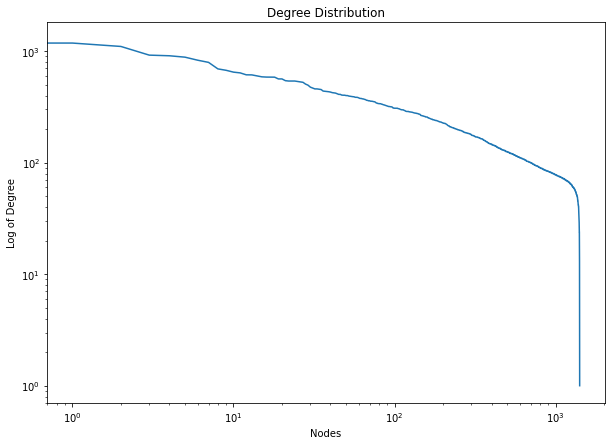

In [14]:
plt.title('Degree Distribution')
plt.ylabel('Log of Degree')
plt.xlabel('Nodes')
tmp = sorted([B.degree[feature] for feature in featureset], reverse = True)
plt.loglog(tmp)
plt.show()

In [15]:
B.remove_nodes_from(list(nx.isolates(B)))

In [16]:
B.number_of_nodes(), B.number_of_edges()

(9656, 197494)

In [17]:
G = nx.Graph()
for feature1 in featureset:
    for user in B.adj[feature1]:
        for feature2 in B.adj[user]:
            if feature2 >= feature1:
                continue
            if G.has_edge(feature1,feature2):
                G[feature1][feature2]['weight'] += 1
                #G[feature1][feature2]['albums'].add(album)
                #G[feature1][feature2]['users'].add(user)
            else:
                #G.add_edge(feature1, feature2, weight = 1, albums = {album})
                #G.add_edge(feature1, feature2, weight = 1, users = {user})
                G.add_edge(feature1, feature2, weight = 1)
G.number_of_nodes(), G.number_of_edges()

(1410, 992109)

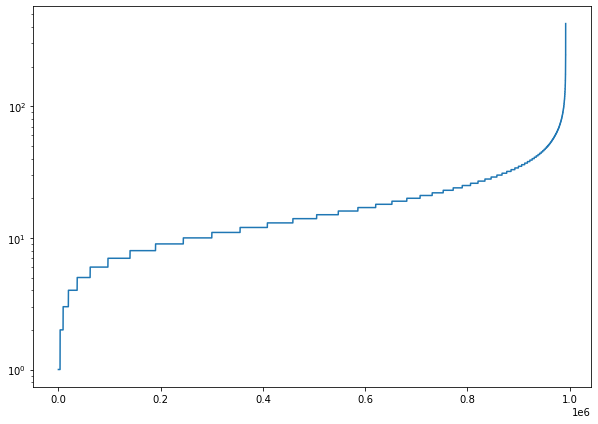

In [18]:
plt.semilogy(sorted(list(nx.get_edge_attributes(G,'weight').values())))
plt.show()

In [19]:
G3 = G.copy()
for u,v in G3.edges():
    if G3[u][v]['weight'] <= 1:
        G.remove_edge(u,v)
print(len(list(nx.isolates(G))))
G.remove_nodes_from(list(nx.isolates(G)))
G.number_of_nodes(), G.number_of_edges()

1


(1409, 988882)

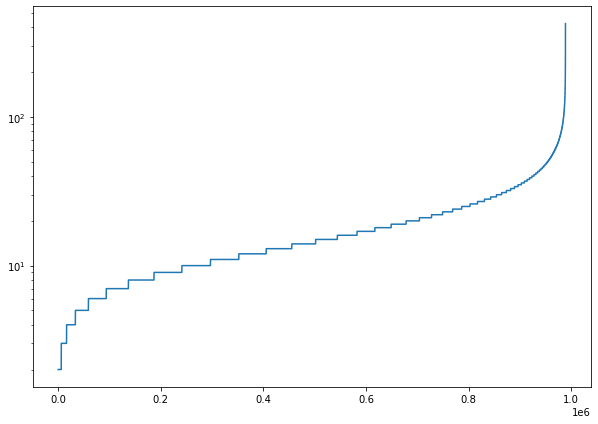

In [20]:
plt.semilogy(sorted(list(nx.get_edge_attributes(G,'weight').values())))
plt.show()

In [21]:
def get_kcore(Graph):
    K = Graph.copy()
    K.remove_edges_from(nx.selfloop_edges(K))
    K = nx.k_core(K)
    sortbylen = lambda cc : len(cc)
    return nx.Graph(K.subgraph(sorted(list(nx.connected_components(K)), key = sortbylen)[-1]))

In [22]:
#G = get_kcore(G)
G.number_of_nodes(), G.number_of_edges()

(1409, 988882)

In [23]:
def normalize_weights(Graph):
    weights = list(nx.get_edge_attributes(G,'weight').values())
    maxi = max(weights)
    mini = min(weights)
    for u,v in Graph.copy().edges():
        Graph[u][v]['weight'] = (Graph[u][v]['weight'] - mini + 1)*100/(maxi-mini)
    return Graph

In [24]:
#G = normalize_weights(G)

In [25]:
partitions = best_partition(G,randomize = True, weight = 'weight')
print(max(partitions.values()))
partitions_by_cluster = {i:[] for i in range(max(partitions.values())+1)}
for node in partitions:
    partitions_by_cluster[partitions[node]].append(node)
clusters = [G.subgraph(partitions_by_cluster[i]) for i in range(max(partitions.values())+1)]

2


In [26]:
modularity(partitions, G, weight = 'weight')

0.021253060321380857

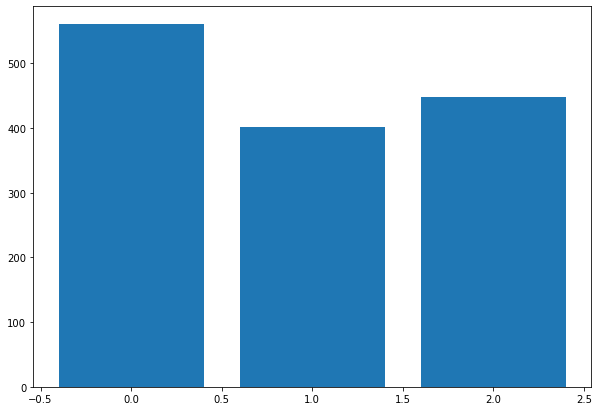

In [27]:
tmp = clt.Counter(list(partitions.values()))
plt.bar(tmp.keys(),tmp.values())
plt.show()

In [28]:
condensed_genres = [genre_group[genre] for genre in all_genres if genre in genre_group]
genre_freq = clt.Counter(condensed_genres)
#genre_freq = clt.Counter(all_genres)

def printCluster(ind, use_kcore = False):
    Graph = clusters[ind]
    if use_kcore:
        Graph = get_kcore(Graph)
    genre_list = []
    albums = set()
    for u,v in Graph.edges():
        albums = albums.union(G[u][v]['albums'])
    for album in albums:
        genre_list += [genre_group[genre] for genre in album_to_genre[album] if genre in genre_group]
    tmp = clt.Counter(genre_list)
    '''
    for key in tmp:
        #print(key,tmp[key], genre_freq[key], len(genre_list), len(G[u][v]['albums']))
        tmp[key] /= genre_freq[key] #percentage
        tmp[key] = round(tmp[key],2)
    '''
    #tmp = {k: v for k, v in sorted(tmp.items(), key=lambda item: item[1], reverse = True)}
    #print(tmp)
    print()
    print(Graph.nodes())
    

11 [220, 222, 118, 145, 208, 48, 113, 85, 66, 96, 88]


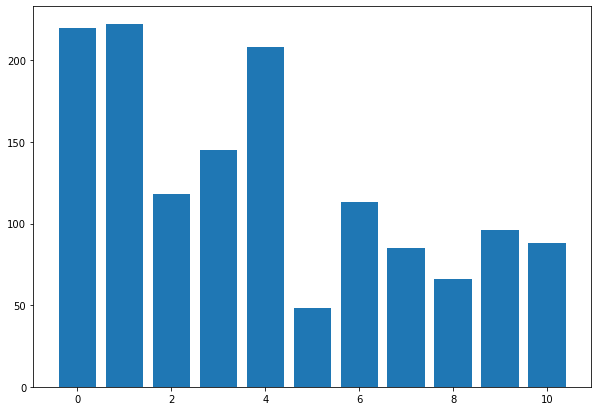

In [29]:
clusters_new = []

for cluster in clusters:
    partitions = best_partition(cluster,randomize = True, weight = 'weight')
    partitions_by_cluster = {i:[] for i in range(max(partitions.values())+1)}
    for node in partitions:
        partitions_by_cluster[partitions[node]].append(node)
    subclusters = [cluster.subgraph(partitions_by_cluster[i]) for i in range(max(partitions.values())+1)]
    clusters_new += subclusters

print(len(clusters_new), [cluster.number_of_nodes() for cluster in clusters_new])
plt.bar([i for i in range(len(clusters_new))],[cluster.number_of_nodes() for cluster in clusters_new])
plt.show()